## math_tutoring_2020

Project to determine the impact math and tutoring workshops have on student outcomes.

### Data Sources
- file1 : Link to SF Report
- file2:  Link to SF Report (As Needed)
- file3:  Link to SF Report (As Needed)

### Changes
- 10-07-2020 : Started project

In [81]:
# ALWAYS RUN
# General Setup 

%load_ext dotenv
%dotenv

import pandas as pd
from pathlib import Path
from datetime import datetime
import os
import numpy as np


The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
cannot find .env file


In [2]:

project_id = "learning-agendas"



In [146]:

# Download data and save to a CSV. If data needs to be refreshed the CSV needs to be deleted.
filename = '../data/raw/test_attendance_data.csv'
table_name = 'gathered_test_attendance_at_data'

if os.path.exists(filename):
    # Read from CSV if already written to avoid repeatedly transferring data from BigQuery
    df = pd.read_csv(filename)
    df = df.drop('Unnamed: 0', axis=1)
else:      
    query = 'SELECT * FROM `learning-agendas.math_tutoring_2020.' + table_name + '`'
    df = pd.read_gbq(query, project_id=project_id)
    df.to_csv(filename)

In [136]:
df.columns

Index(['Student__c', 'Contact_Id', 'High_School_Class__c', 'AT_Id',
       'GPA_semester_cumulative__c', 'HS_11th_Cum_GPA', 'GAS_Name',
       'site_short', 'ACT_English_highest_official__c',
       'ACT_Highest_Composite_official__c', 'ACT_Math_highest_official__c',
       'ACT_Reading_highest_official__c', 'ACT_Superscore_highest_official__c',
       'SAT_Highest_Total_single_sitting__c', 'SAT_Math_highest_official__c',
       'SAT_Reading_Writing_highest_official__c', 'SAT_SuperScore_Official__c',
       'AT_Grade__c', 'student_audit_status__c', 'Start_Date__c', 'AY_Name',
       'Attendance_Numerator', 'Attendance_Denominator', 'mod_duration',
       'mod_dosage_type', 'Academic_Semester__c', 'Contact_Name__c',
       'max_act_composite', 'max_act_math', 'max_act_english',
       'max_act_reading', 'max_sat_math', 'max_sat_total', 'max_sat_english'],
      dtype='object')

Student__c                                 1.000000
mod_duration                               1.000000
site_short                                 1.000000
GAS_Name                                   1.000000
AT_Grade__c                                1.000000
student_audit_status__c                    1.000000
Start_Date__c                              1.000000
AY_Name                                    1.000000
Attendance_Denominator                     1.000000
Attendance_Numerator                       1.000000
mod_dosage_type                            1.000000
AT_Id                                      1.000000
High_School_Class__c                       1.000000
Contact_Id                                 1.000000
ACT_Highest_Composite_official__c          0.985534
HS_11th_Cum_GPA                            0.971196
ACT_English_highest_official__c            0.742990
ACT_Superscore_highest_official__c         0.742990
ACT_Reading_highest_official__c            0.742990
ACT_Math_hig

<AxesSubplot:>

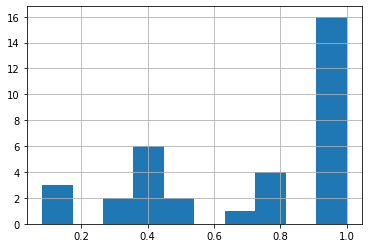

In [145]:
print((df.notnull().sum()/df.shape[0]).sort_values(ascending=False).to_string())
(df.notnull().sum()/df.shape[0]).hist()

<AxesSubplot:>

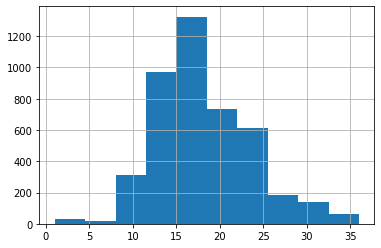

In [39]:
df.max_act_reading.hist()

In [92]:
sat_to_act_math = pd.read_csv('../data/raw/sat_to_act_math.csv')
sat_to_act_english_reading = pd.read_csv('../data/raw/sat_to_act_english_reading.csv')

In [113]:
def convert_sat_to_act(sat_score, conversion_file, act_score):

    try: 
        conversion_score = conversion_file[sat_score >= conversion_file.SAT].reset_index().iloc[0]['ACT']
        if pd.isna(act_score):
            return conversion_score
        elif conversion_score >= act_score:
            return conversion_score
        else:
            return act_score
    except:
        return act_score
     

In [115]:
df["max_act_english_reading"] = df.max_act_english + df.max_act_reading

In [116]:
df["max_converted_math"] = df.apply(lambda x: convert_sat_to_act(
    x['max_sat_math'], sat_to_act_math, x['max_act_math']), axis=1)


In [121]:
df["max_converted_english_reading"] = df.apply(lambda x: convert_sat_to_act(
    x['max_sat_english'], sat_to_act_english_reading, x['max_act_english_reading']), axis=1)


In [128]:
df["max_converted_english"] = df.apply(lambda x: convert_sat_to_act(
    x['max_sat_english'], sat_to_act_math, x['max_act_english']), axis=1)


In [129]:
df["max_converted_reading"] = df.apply(lambda x: convert_sat_to_act(
    x['max_sat_english'], sat_to_act_math, x['max_act_reading']), axis=1)


In [147]:
df.loc[pd.isna(df.mod_duration), "mod_duration_filled"] = df.loc[pd.isna(
    df.mod_duration), "Attendance_Numerator"] * 60

In [149]:
df.loc[~pd.isna(df.mod_duration), "mod_duration_filled"] = df.loc[~pd.isna(df.mod_duration), "mod_duration"]

### Save output file into processed directory

Save a file in the processed directory that is cleaned properly. It will be read in and used later for further analysis.

In [ ]:
# Save File 1 Data Frame (Or master df)
df.to_pickle(summary_file)